# Assignment 3 on Natural Language Processing

## Date : 30th Sept, 2020

### Instructor : Prof. Sudeshna Sarkar

### Teaching Assistants : Alapan Kuila, Aniruddha Roy, Anusha Potnuru, Uppada Vishnu

The central idea of this assignment is to use Naive Bayes classifier and LSTM based classifier and compare the models by accuracy on IMDB dataset.



Please submit with outputs. 

In [194]:
import re
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import keras
from sklearn.metrics import classification_report
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [195]:
#Load the IMDB dataset. You can load it using pandas as dataframe
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [196]:
dataset = pd.read_csv("/content/drive/My Drive/CS60075-NLP/Assignment-3/IMDB Dataset.csv")
dataset.head(20)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


# Preprocessing
PrePrecessing that needs to be done on lower cased corpus

1. Remove html tags
2. Remove URLS
3. Remove non alphanumeric character
4. Remove Stopwords
5. Perform stemming and lemmatization

You can use regex from re. 

In [197]:
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

In [198]:

def preprocess(input_str):
  input_str = input_str.lower()
  input_str = re.sub(r"http\S+", "", input_str)
  input_str = re.sub(r'https?:\/\/.*[\r\n]*', '', input_str)
  input_str = re.compile(r'<[^>]+>').sub("",input_str)   #removing html tags 
  input_str = re.sub(r"[^a-zA-Z0-9]+", " ", input_str)
  input_list = word_tokenize(input_str)
  stop_words = set(stopwords.words('english'))
  filtered_sentence = [w for w in input_list if not w in stop_words]
  # ps = PorterStemmer()
  # pstemmed_words = [ps.stem(w) for w in filtered_sentence]

  lemmatizer = WordNetLemmatizer()
  lem_words = [lemmatizer.lemmatize(w,pos="n") for w in filtered_sentence] 
  s = ' '.join(lem_words)
  return s 

dataset["review"] = dataset["review"].apply(preprocess)


dataset.head(5)

,review,sentiment
0,one reviewer mentioned watching 1 oz episode h...,positive
1,wonderful little production filming technique ...,positive
2,thought wonderful way spend time hot summer we...,positive
3,basically family little boy jake think zombie ...,negative
4,petter mattei love time money visually stunnin...,positive


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


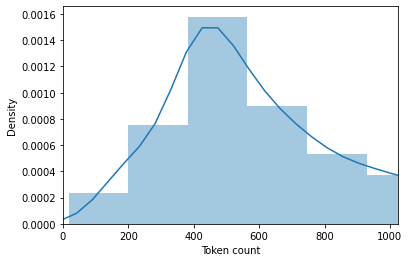

In [199]:
# Print Statistics of Data like avg length of sentence , proposition of data w.r.t class labels

import seaborn as sns
import matplotlib.pyplot as plt
token_lens = []
for txt in dataset.review[0:]:
  token_lens.append(len(txt))
sns.distplot(token_lens)
plt.xlim([0, 1024]);
plt.xlabel('Token count');


In [200]:
sentences_stat = []
sents = dataset["review"].tolist()
for sent in sents:
  tokens = word_tokenize(sent)
  sentences_stat.append(tokens)


In [201]:
#average length of of sentence
review_len = [len(s) for s in sentences_stat]
print("\nAverage length of review: {}".format(np.mean(review_len)))
print("\n max length of review: {}".format(np.max(review_len)))


Average length of review: 119.56176

 max length of review: 1429


<BarContainer object of 2 artists>

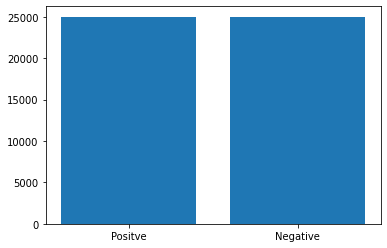

In [202]:
pos=0
neg=0
for txt in dataset.sentiment[0:]:
  if txt=='positive':
    pos = pos+1
  else:
    neg=neg+1
plt.bar(['Positve','Negative'],[pos,neg])

# Naive Bayes classifier

In [203]:
# get reviews column from df
reviews = dataset["review"]

# get labels column from df
labels = dataset["sentiment"]

In [204]:
# Use label encoder to encode labels. Convert to 0/1
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(labels)

print(encoder.classes_)
print(encoded_labels)

['negative' 'positive']
[1 1 1 ... 0 0 0]


In [205]:
# Split the data into train and test (80% - 20%). 

# Use stratify in train_test_split so that both train and test have similar ratio of positive and negative samples.
train_sentences, test_sentences, train_labels, test_labels = train_test_split(reviews,encoded_labels, test_size=0.2,random_state=0 ,stratify=encoded_labels)
# train_sentences, test_sentences, train_labels, test_labels 

Here there are two approaches possible for building vocabulary for the naive Bayes.
1. Take the whole data (train + test) to build the vocab. In this way while testing there is no word which will be out of vocabulary.
2. Take the train data to build vocab. In this case, some words from the test set may not be in vocab and hence one needs to perform smoothing so that one the probability term is not zero.
 
You are supposed to go by the 2nd approach.
 
Also building vocab by taking all words in the train set is memory intensive, hence you are required to build vocab by choosing the top 2000 - 3000 frequent words in the training corpus.

> $ P(x_i | w_j) = \frac{ N_{x_i,w_j}\, +\, \alpha }{ N_{w_j}\, +\, \alpha*d} $


$N_{x_i,w_j}$ : Number of times feature $x_i$ appears in samples of class $w_j$

$N_{w_j}$ : Total count of features in class $w_j$

$\alpha$ : Parameter for additive smoothing. Here consider $\alpha$ = 1

$d$ : Dimentionality of the feature vector  $x = [x_1,x_2,...,x_d]$. In our case its the vocab size.






In [206]:
from sklearn.feature_extraction.text import CountVectorizer
# Use Count vectorizer to get frequency of the words
'''
max_features parameter : If not None, build a vocabulary that only consider the top max_features ordered by term frequency across the corpus.
vec = CountVectorizer(max_features = 3000)
X = vec.fit_transform(Sentence_list)
'''
vec = CountVectorizer(max_features = 3000)
X = vec.fit_transform(train_sentences)


V = X.toarray()
Vocab = vec.vocabulary_
Vocab
V.shape



(40000, 3000)

In [207]:
# Vocab
# print(s[1])

In [208]:
def count_reviews(reviews, ys,vocabulary):
    result = {}
    for y,review in zip(ys, reviews):
      word_list = word_tokenize(review)
      for word in word_list:
            # define the key, which is the word and label tuple
          pair = (word,y)
            # if the key exists in the dictionary, increment the count
          if pair in result:
            result[pair] += 1
            # else, if the key is new, add it to the dictionary and set the count to 1
          else:
            result[pair] = 1
    return result

In [210]:
freqs = count_reviews(train_sentences,train_labels,Vocab)

In [211]:
N_pos =0 
N_neg = 0
for word in Vocab.keys() :
  N_pos += freqs.get((word,1),0)
  N_neg += freqs.get((word,0),0)
print(N_pos)
print(N_neg)

1849840
1832553


In [141]:
# Use laplace smoothing for words in test set not present in vocab of train set
#implemented directly in function/cell below 

In [212]:
# Build the model. Don't use the model from sklearn
def  naive_bayes_predict(freqs,word_list,vocab_size,N_pos,N_neg,Vocab):
  p = 0
  prob_pos=0
  prob_neg=0
  for word in word_list:
    if word in Vocab.keys():
      prob_pos += np.log(freqs.get((word,1),0)+1/(N_pos+vocab_size))
      prob_neg += np.log(freqs.get((word,0),0)+1/(N_neg+vocab_size))
      # prob_pos = (prob_pos) * (freqs.get((word,1),0)+1/(N_pos+vocab_size))
      # prob_neg = (prob_neg) * (freqs.get((word,0),0)+1/(N_neg+vocab_size))
    else :
      prob_pos +=  np.log(1/(N_pos+vocab_size))
      prob_neg += np.log(1/(N_neg+vocab_size))
      # prob_pos =  1/(N_pos+vocab_size)
      # prob_neg = 1/(N_neg+vocab_size)
  prob_pos += np.log(N_pos/(N_pos+N_neg))
  prob_neg+= np.log(N_neg/(N_pos+N_neg))
  # prob_pos *= (N_pos/(N_pos+N_neg))
  # prob_neg *= (N_neg/(N_pos+N_neg)) 

  p = (prob_pos-prob_neg)
  if p>0:
    return 1
  else :
    return 0

In [216]:
# Test the model on test set and report Accuracy
y_hat = []
for sentence in test_sentences:
  y_hat_i = naive_bayes_predict(freqs,word_tokenize(sentence),3000,N_pos,N_neg,Vocab)
  y_hat.append(y_hat_i)


In [217]:

test_y = test_labels.tolist()
hat_y = np.array(y_hat)
error = np.mean(np.absolute(hat_y-test_labels))
accuracy = 1-error
accuracy

0.8455

In [218]:
corr = 0
total = 10000
for i in range(len(y_hat)):
  if y_hat[i] == test_labels[i]:
    corr+=1
print(corr)

8455


# *LSTM* based Classifier

Use the above train and test splits.

In [219]:
# Hyperparameters of the model
vocab_size = 3000 # choose based on statistics
oov_tok = '<OOK>'
embedding_dim = 100
max_length = 200 # choose based on statistics, for example 150 to 200
padding_type='post'
trunc_type='post'

In [220]:
# tokenize sentences
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

# convert train dataset to sequence and pad sequences
train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, padding='post', maxlen=max_length)

# convert Test dataset to sequence and pad sequences
test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_sequences, padding='post', maxlen=max_length)

In [224]:
# model initialization
model = keras.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    keras.layers.Bidirectional(keras.layers.LSTM(64)),
    keras.layers.Dense(24, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

# compile model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 100)          300000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               84480     
_________________________________________________________________
dense_2 (Dense)              (None, 24)                3096      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 25        
Total params: 387,601
Trainable params: 387,601
Non-trainable params: 0
_________________________________________________________________


In [225]:
num_epochs = 5
history = model.fit(train_padded, train_labels, 
                    epochs=num_epochs, verbose=1, 
                    validation_split=0.1)

Epoch 1/5
1125/1125 [==============================] - 232s 206ms/step - loss: 0.3908 - accuracy: 0.8209 - val_loss: 0.3073 - val_accuracy: 0.8785
Epoch 2/5
1125/1125 [==============================] - 230s 204ms/step - loss: 0.2733 - accuracy: 0.8902 - val_loss: 0.2977 - val_accuracy: 0.8848
Epoch 3/5
1125/1125 [==============================] - 229s 203ms/step - loss: 0.2422 - accuracy: 0.9044 - val_loss: 0.3085 - val_accuracy: 0.8867
Epoch 4/5
1125/1125 [==============================] - 230s 205ms/step - loss: 0.2101 - accuracy: 0.9186 - val_loss: 0.3198 - val_accuracy: 0.8690
Epoch 5/5
1125/1125 [==============================] - 229s 204ms/step - loss: 0.1865 - accuracy: 0.9285 - val_loss: 0.3629 - val_accuracy: 0.8685


In [226]:
# Calculate accuracy on Test data

prediction = model.predict(test_padded)

# Get probabilities

# Accuracy : one can use classification_report from sklearn

# Calculate accuracy on Test data
# Get probabilities
prediction = model.predict(test_padded)

# Get labels based on probability 1 if p>= 0.5 else 0
prediction = prediction>=0.5

# Accuracy : one can use classification_report from sklearn
correct_predictions=0
for i in range(len(test_labels)):
  if prediction[i]==test_labels[i]:
    correct_predictions = correct_predictions+1

accuracy = correct_predictions/len(test_labels)
print(accuracy)

0.8632


In [227]:
from sklearn.metrics import classification_report
print(classification_report(test_labels, prediction))

              precision    recall  f1-score   support

           0       0.83      0.92      0.87      5000
           1       0.91      0.81      0.85      5000

    accuracy                           0.86     10000
   macro avg       0.87      0.86      0.86     10000
weighted avg       0.87      0.86      0.86     10000



## Get predictions for random examples

In [228]:
# reviews on which we need to predict
sentence = ["The movie was very touching and heart whelming", 
            "I have never seen a terrible movie like this", 
            "the movie plot is terrible but it had good acting"]

# convert to a sequence
sequences = tokenizer.texts_to_sequences(sentence)

# pad the sequence
padded = pad_sequences(sequences, padding='post', maxlen=max_length)

# Get probabilities
# print(model.predict(padded))
pred = model.predict(padded)
# Get labels based on probability 1 if p>= 0.5 else 0
pred = pred>=0.5 
pred = pred +1 -1
print(pred)


[[1]
 [0]
 [0]]
